# Some simple correlations between inflation and output
## Caio Machado
## Macroeconomics II

### This is a complement to lecture note #4.

In [1]:
### Preamble
using Plots, RCall, DataFrames, DataFramesMeta, StatFiles, Statistics
gr(legend=false,linewidth=2)

# R packages used through RCall:
R"""
foo <- c("tidyverse","lptools","lfe")
pacman::p_load(char = foo)
""";

## 1. Downloading and formatting the data

First, we download and load data from the Macro History Database (see https://www.macrohistory.net/database/):

In [2]:
download("http://data.macrohistory.net/JST/JSTdatasetR5.dta","Jorda.dta")
df = DataFrame(load("Jorda.dta"))

,year,country,iso,ifs,pop,rgdpmad,rgdppc,rconpc,gdp
,Float64?,String?,String?,Int16?,Float64?,Float64?,Float64?,Float64?,Float64?
1,1870.0,Australia,AUS,193,1775.0,3273.24,13.8362,21.4497,208.78
2,1871.0,Australia,AUS,193,1675.0,3298.51,13.9369,19.9308,211.56
3,1872.0,Australia,AUS,193,1722.0,3553.43,15.0442,21.085,227.4
4,1873.0,Australia,AUS,193,1769.0,3823.63,16.2194,23.2549,266.54
5,1874.0,Australia,AUS,193,1822.0,3834.8,16.2682,23.458,287.58
6,1875.0,Australia,AUS,193,1874.0,4138.21,17.5921,25.6695,300.74
7,1876.0,Australia,AUS,193,1929.0,4007.26,17.019,24.8062,311.26
8,1877.0,Australia,AUS,193,1995.0,4036.09,17.1457,25.2171,313.66
9,1878.0,Australia,AUS,193,2062.0,4277.4,18.2053,26.5606,324.3


This data includes a consumer pricel level (CPI) for each country, that we can use to compute the inflation and average inflation for each country:

In [3]:
@rput df # Send dataframe to R (can do it in Julia as well)
R"""
df <- df %>%
    group_by(iso) %>% # Groups data by country (code iso)
    mutate(inflation = get_logdif(cpi), growth = get_logdif(rgdppc),
    moneygr = get_logdif(money)) %>% # Computes inflation rate as log change in CPI, GDP growth (per capita) and money growth
    mutate(mean_inflation = mean(inflation,na.rm=TRUE), mean_growth = mean(growth,na.rm=TRUE)) %>% # Computes average inflation and GDP growth for each country
    ungroup()

# Data frame with only averages for each country:
df2 <- df %>%
    filter(year == 2000) %>% # Select one row only for each country
    select(country,mean_growth,mean_inflation)
"""
@rget df df2 # Back to Julia

,country,mean_growth,mean_inflation
,String,Float64,Float64
1,Australia,0.014417,0.0290366
2,Belgium,0.0162052,0.0372479
3,Canada,0.0186075,0.0223867
4,Switzerland,0.0140267,0.0157424
5,Germany,0.0162495,0.205991
6,Denmark,0.0168414,0.0274442
7,Spain,0.0187635,0.0449324
8,Finland,0.0206389,0.0543435
9,France,0.016421,0.0530223


## 2. Long run correlations

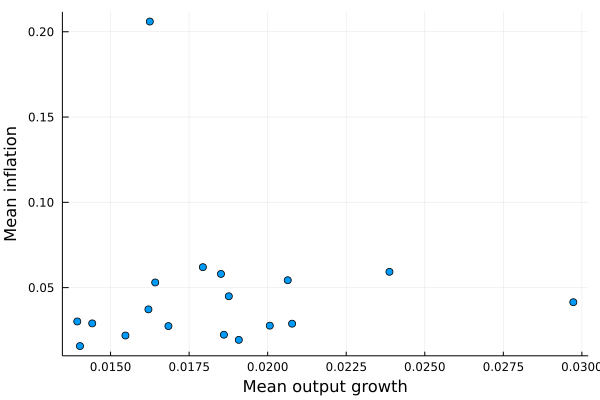

In [4]:
plot(df2.mean_growth,df2.mean_inflation,seriestype = :scatter,xlabel="Mean output growth",ylabel="Mean inflation")

Let's remove Germany... 

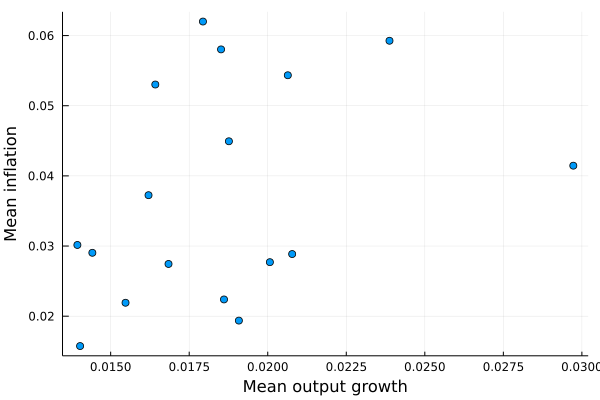

In [5]:
df2 = df2[df2.country .!= "Germany",:]
plot(df2.mean_growth,df2.mean_inflation,seriestype = :scatter,xlabel="Mean output growth",ylabel="Mean inflation")

If anything, the correlation is positive:

In [6]:
cor(df2.mean_growth,df2.mean_inflation)

0.3491940869663594

## 3. Dynamic responses of output to inflation

Let's look at the data trying to better explore the information contained in the dynamics of it. For horizons $k\in\{0,1,2,...,12\}$ we run the following OLS regressions (for details, see Jorda 2005 paper in the AER):

$$\Delta_{k} y_{i, t+k}=\alpha_{i}^{k}+\beta_k \pi_t +\Gamma^{k} X_{i, t}+\epsilon_{i, t}^{k}$$

where countries are denoted by subscripts $i$, $\Delta_{k} y_{i, t+k}$ represents the log change in output between years $t-1$ and $t+k$, $\alpha_i^k$ is a country fixed effect (that is, there is a dummy variable for each country), and $X_{it}$ is a vector of additional controls, that can include both contemporaneous or lagged variables. For instance, the $\beta_2$ estimated by OLS gives an estimate of the two-year change in log output conditional in a unit increase in inflation two years ago, after controlling for the variables in $X_{i, t}$.

Running this regression is not difficult, but requires some manipulation of the data. Here I will use functions in a package I created for personal use that can handle that (https://github.com/caiohm/lptools). In the control vector $X_{it}$ I include lagged inflation and log changes in output up to 3 lags.

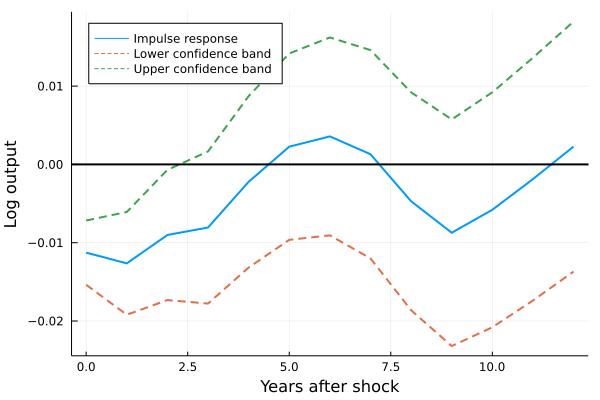

In [7]:
R"""
exogl <- c("growth","inflation") # Lagged exogenous variables
exogc <- c("inflation") # Contemporaneous exogenous variables
lags <- 3
horizon <- 12
results <- local_projection(df,"growth",exogc,exogl,shock = "inflation",lags,
                             horizon,method = felm,append_formula="| country",conf_level=0.9, 
                             id = "country", time = "year",cmethod = "reghdfe")
irf <- results$irf
h <- results$h
conf_low <- results$conf_low
conf_high <- results$conf_high
"""
@rget irf h conf_low conf_high
plot(h,irf,ylabel="Log output",xlabel="Years after shock",label="Impulse response",legend=:topleft)
plot!(h,conf_low,linestyle=:dash,label="Lower confidence band")
plot!(h,conf_high,linestyle=:dash,label="Upper confidence band")
hline!([0],color="black",label=false)

A change of inflation from 5% to, say, 6%, is associated to output losses close to 1 percentage point in the first years, but soon that change disappears (the coefficients are not statiscally different from zero as reported by the confidence bands). This is consistent with inflation affecting output in the short run, but not in the long run. Those are just correlations, however, and one should be careful when interpreting those results. For instance, economists often argue that higher inflation is associated to higher output in the short run (the Phillips curve), which at a first glance seems inconsistent with the results found. We may have found a negative sign in the short run perhaps because periods of high inflation are also periods of negative supply shocks (which are not controled for in the regressions). 

For a proper empirical analysis of the long run real effects of monetary policy one needs a proper identification strategy to infer causality (if you feel curious see Jorda, Singh and Taylor (2020), _"The Long-Run Effects of Monetary Policy"_).